# Determining the outflow of customers of telecom companies

## Description

### The task of the project

The operator of the NIDIDINEALARISTICA.Com communications wants to learn how to predict the outflow of customers.If it turns out that the user plans to leave, he will be offered promotional codes and special conditions.The operator’s team has collected personal data on some customers, information about their tariffs and contracts.

### Description of services

The operator provides two main types of services:

1. Stationary telephone.It is possible to connect the telephone to several lines at the same time.
2. Internet.The connection can be of two types: through the telephone line (DSL*,*from the English.*Digital Subscriber Line*, the “Digital Subscriber Line”) or the fiber -fiber cable (*Fiber Optic*).

Such services are also available:

- Internet security: Antivirus (*DeviceProtection*) and blocking unsafe sites (*Onlinesecurity*);
- dedicated technical support line (*techsupport*);
- cloud storage of files for backup data (*OnlineBackup*);
- Streaming television (*Streamingtv*) and a catalog of films (*StreamingMovies*).

Clients can pay for services every month or conclude an agreement for 1-2 years.Various calculation methods and the possibility of obtaining an electronic check are available.

### Data Description

The data consist of files obtained from different sources:

- [contract_new.csv](https://code.s3.yandex.net/datasets/contract_new.csv) - information about the contract;
- [personal_new.csv](https://code.s3.yandex.net/datasets/personal_new.csv) - personal data of the client;
- [Internet_new.csv](https://code.s3.yandex.net/datasets/internet_new.csv)- information on Internet services;
- [Phone_new.csv](https://code.s3.yandex.net/datasets/phone_new.csv) - Information about telephony services.


Data field description:

- `BeginDate` - the start date of the services,
- `EndDate` - date of completion of the service,
- `Type` - type of payment: monthly, annual, etc.
- `PaperlessBilling` - electronic payment document,
- `PaymentMethod` - a payment method,
- `MonthlyCharges` - monthly spending on services,
- `Totalchangs` - all money was spent on services
- `Dependents` - the presence of dependents
- `SeniorCitizen` - the presence of pension status by age
- `Partner` - the presence of a spouse (and)
- `MultipleLines` - the presence of the possibility of conducting parallel lines during the call

In all files, the column `customerID` contains the customer code.

Information about contracts is relevant for February 1, 2020.

Data is also in the simulator, in the `/datasets/` folder

## Import and initial data inspection

In [1]:
import pandas as pd
import numpy as np
import os.path

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from scipy.stats import chi2_contingency
import phik

from sklearn.model_selection import KFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 240423

Import datasets using try/except and set the date column as index

In [2]:
print('Loading dataset "contract_new.csv"')
try:
    contract_path_df = os.path.join('datasets/contract_new.csv')
    contract_df = pd.read_csv(contract_path_df)
    print('data loaded from local storage')
except:
    contract_df = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    print('data loaded from server')

print('Loading dataset "personal_new.csv"')
try:
    personal_path_df = os.path.join('datasets/personal_new.csv')
    personal_df = pd.read_csv(personal_path_df)
    print('data loaded from local storage')
except:
    personal_df = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    print('data loaded from server')

print('Loading dataset "internet_new.csv"')
try:
    internet_path_df = os.path.join('datasets/internet_new.csv')
    internet_df = pd.read_csv(internet_path_df)
    print('data loaded from local storage')
except:
    internet_df = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    print('data loaded from server')

print('Loading dataset "phone_new.csv"')
try:
    phone_path_df = os.path.join('datasets/phone_new.csv')
    phone_df = pd.read_csv(phone_path_df)
    print('data loaded from local storage')
except:
    phone_df = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')
    print('data loaded from server')

Loading dataset "contract_new.csv"
data loaded from local storage
Loading dataset "personal_new.csv"
data loaded from local storage
Loading dataset "internet_new.csv"
data loaded from local storage
Loading dataset "phone_new.csv"
data loaded from local storage


In [3]:
df_list = [contract_df, personal_df, internet_df, phone_df]
df_name = ['contract_df', 'personal_df', 'internet_df', 'phone_df']

for i,n in zip(df_list, df_name):
    text = f'  dataset info {n}  '
    print(f'{text:~^79}')
    display(i.info())
    display(i.head(5))
    display(i.describe())

~~~~~~~~~~~~~~~~~~~~~~~~~  dataset info contract_df  ~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.8500,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.9500,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.8500,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3000,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7000,353.5


,MonthlyCharges
count,7043.0000
mean,64.7617
std,30.0900
min,18.2500
25%,35.5000
50%,70.3500
75%,89.8500
max,118.7500


~~~~~~~~~~~~~~~~~~~~~~~~~  dataset info personal_df  ~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.0000
mean,0.1621
std,0.3686
min,0.0000
25%,0.0000
50%,0.0000
75%,0.0000
max,1.0000


~~~~~~~~~~~~~~~~~~~~~~~~~  dataset info internet_df  ~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


~~~~~~~~~~~~~~~~~~~~~~~~~~~  dataset info phone_df  ~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


In [4]:
contract_df['EndDate'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

In [5]:
# убедимся что поля customerID в датасетах содержат только уникальные значения
for i, n in zip(df_list, df_name):
    print(' "customerID" duplicates in dataset ' + n + ':', i['customerID'].duplicated().sum())

 "customerID" duplicates in dataset contract_df: 0
 "customerID" duplicates in dataset personal_df: 0
 "customerID" duplicates in dataset internet_df: 0
 "customerID" duplicates in dataset phone_df: 0


### Conclusions about the initial inspection of data

- the names of the columns would be good to write down in the snake register, and not in the camel
- In Dataset there is information about 7043 contracts, while in the dataset with information about the services of the Internet and telephony only 5517 and 6361 records, therefore, not all customers draw up both services.
- Datasets can be combined by the `customerID` field for ease of working with them and comparing data about users and the services they connected
- Fields `BeginDate` and `EndDate` contain dates, but are recorded in the type of data `object`.It is worth fixing it.
- The `EndDate` field contains" No "fields, from which it follows that the user still uses services.This is an important point for us, but it is difficult to use in this form.On the basis of this column, you can create a new column with the category "left/did not leave."In further work, this can be used as a targeted sign for the training of the model
- The `TotalCharges` field contains numerical data on the funds spent, but also recorded in the type of data `object`, the data type should also be changed
- You need to create a sign with 1 for users whose `id` is present in the Dataset with telephony services and 0 for the rest

## Pre-processing

In [6]:
df = contract_df.merge(personal_df, on = 'customerID').merge(internet_df, on = 'customerID', how = 'left').merge(phone_df, on = 'customerID', how = 'left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Let's convert the column names to snake case

In [7]:
def camel_to_snake(str):
    snake_register = ''
    for i in str:
        if i.isupper():
            snake_register += '_' + i.lower()
        else:
            snake_register += i
    return snake_register.lstrip('_')

df.columns = [camel_to_snake(i) for i in df.columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_i_d       7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

Overall the function did an acceptable job, there are only two columns where the result is not satisfactory
where there were 2 capital letters in a row the extra symbol "_" is not needed, we will fix it manually

In [8]:
df = df.rename(columns={
    'customer_i_d': 'customer_id', 
    'streaming_t_v': 'streaming_tv'
})

Let's get rid of gaps

In [9]:
df['multiple_lines'] = df['multiple_lines'].fillna('no_phone')
df = df.fillna('No')

An attempt to change the data type gives an error, apparently in addition to numeric data we have strings with spaces in which there are no values. Let's check

In [10]:
df[df['total_charges'] == ' ']['total_charges'].count()

11

Yes, that's right, let's replace the spaces with zero values ​​and change the data type again

In [11]:
df['total_charges'] = df['total_charges'].replace(" ", 0).astype('float64')

In [12]:
df.head(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.8500,31.0400,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_phone
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.9500,2071.8400,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.8500,226.1700,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3000,1960.6000,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_phone
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7000,353.5000,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [13]:
col_binar = ['paperless_billing', 'partner', 'dependents', 'online_security', 'online_backup', 'device_protection',
            'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

for col in col_binar:
    df[col] = df[col].apply(lambda x: 0 if x == 'No' else 1)

From the column with the contract end date we will create a new category "left/did not leave"

In [14]:
df['gone'] = df['end_date'].apply(lambda x: 0 if x == 'No' else 1)

It is known that the information is relevant as of February 1, 2020, so we will replace the 'No' values ​​in end_date with this number

In [15]:
df['end_date'] = df['end_date'].replace('No', '2020-02-01')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')
df['begin_date'] = pd.to_datetime(df['begin_date'], format='%Y-%m-%d')

Let's calculate how many months the subscriber used the services, write the result in a separate column, and get rid of the start and end columns

In [16]:
df['user_for_days'] = ((df['end_date'] - df['begin_date']) / np.timedelta64(1, 'D')).astype(int)
df = df.drop(['begin_date','end_date'], axis=1 )

## Data analysis

gone: 15.6%


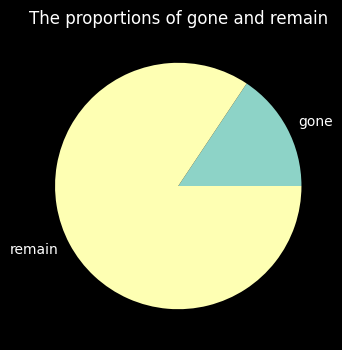

In [17]:
gone_percent = round(df['gone'].mean() * 100, 1)
print(f'gone: {gone_percent }%')
plt.figure(figsize=(4,4))
plt.pie([df['gone'].mean(),1-df['gone'].mean()], labels=['gone', 'remain'])
plt.title('The proportions of gone and remain')
plt.show();

The data contains a class imbalance

### Analysis of categorical signs

We use chi2_contingenscy to determine the statistical significance of signs on the target feature (the client has left)

Zero hypothesis: the sign is not related to the outflow of customers

The value of the threshold `alpha` is determined at 0.05.

~~~~~~~~~~~~~  Testing the null hypothesis on the parameter type  ~~~~~~~~~~~~~


,type,gone,remain
0,Month-to-month,407,3468
1,One year,313,1160
2,Two year,381,1314


p-value: 3.065849096341664e-38
Reject the null hypothesis


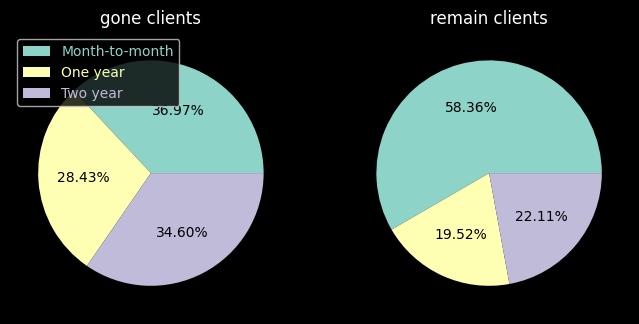

~~~~~~  Testing the null hypothesis on the parameter paperless_billing  ~~~~~~~


,paperless_billing,gone,remain
0,0,380,2492
1,1,721,3450


p-value: 4.846228533723826e-06
Reject the null hypothesis


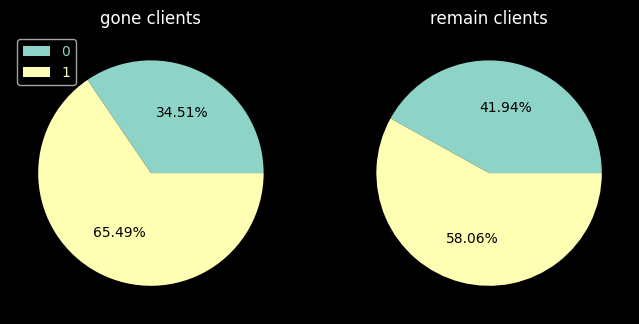

~~~~~~~~  Testing the null hypothesis on the parameter payment_method  ~~~~~~~~


,payment_method,gone,remain
0,Bank transfer (automatic),317,1227
1,Credit card (automatic),317,1205
2,Electronic check,350,2015
3,Mailed check,117,1495


p-value: 1.7359650541850085e-31
Reject the null hypothesis


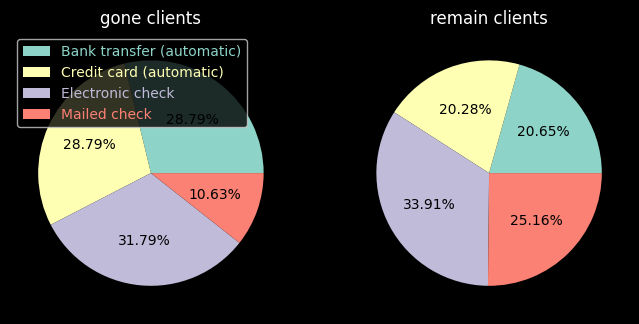

~~~~~~~~~~~~  Testing the null hypothesis on the parameter gender  ~~~~~~~~~~~~


,gender,gone,remain
0,Female,528,2960
1,Male,573,2982


p-value: 0.2712988931477521
Failure to reject the null hypothesis


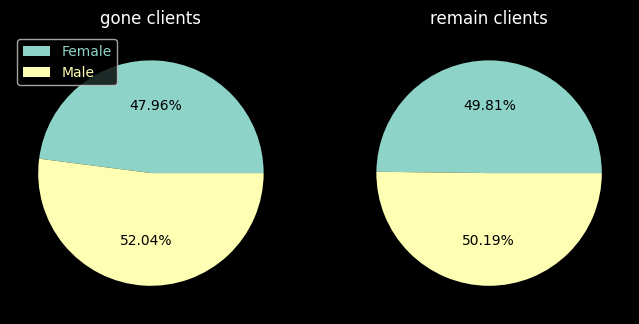

~~~~~~~~~~~  Testing the null hypothesis on the parameter partner  ~~~~~~~~~~~~


,partner,gone,remain
0,0,382,3259
1,1,719,2683


p-value: 1.5331159930026101e-34
Reject the null hypothesis


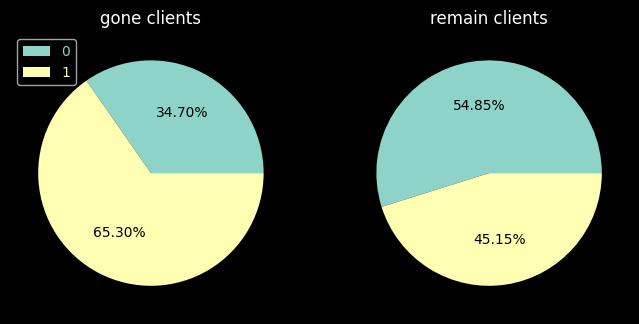

~~~~~~~~~~  Testing the null hypothesis on the parameter dependents  ~~~~~~~~~~


,dependents,gone,remain
0,0,733,4200
1,1,368,1742


p-value: 0.006996418239573212
Reject the null hypothesis


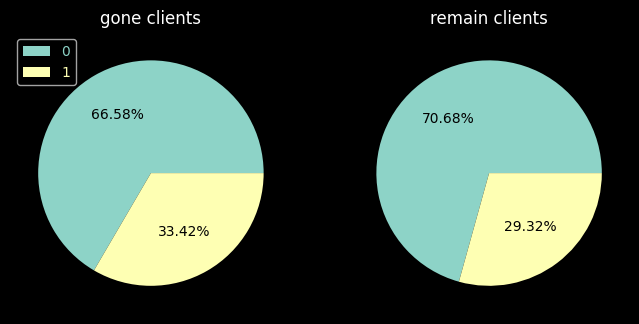

~~~~~~~~  Testing the null hypothesis on the parameter senior_citizen  ~~~~~~~~


,senior_citizen,gone,remain
0,0,869,5032
1,1,232,910


p-value: 2.4066754883142295e-06
Reject the null hypothesis


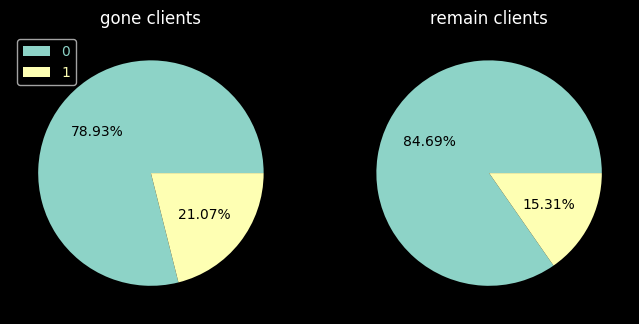

~~~~~~~  Testing the null hypothesis on the parameter internet_service  ~~~~~~~


,internet_service,gone,remain
0,DSL,346,2075
1,Fiber optic,595,2501
2,No,160,1366


p-value: 1.1787764842848554e-14
Reject the null hypothesis


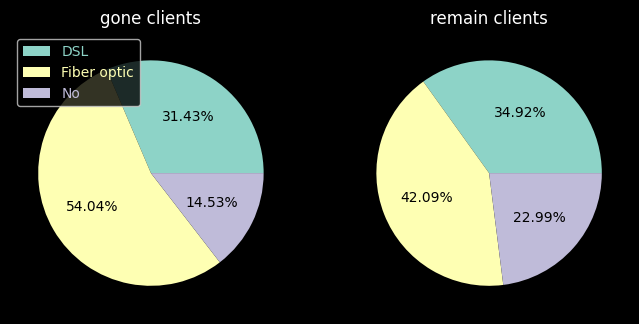

~~~~~~~  Testing the null hypothesis on the parameter online_security  ~~~~~~~~


,online_security,gone,remain
0,0,686,4338
1,1,415,1604


p-value: 7.260860275182705e-13
Reject the null hypothesis


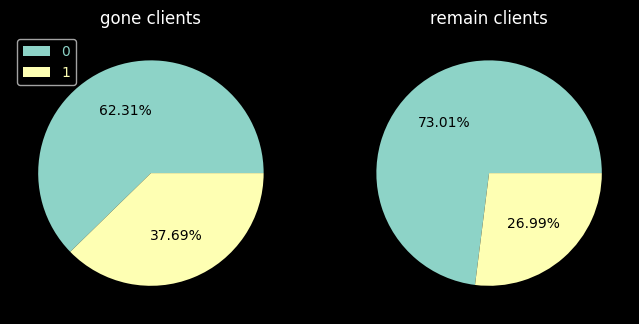

~~~~~~~~  Testing the null hypothesis on the parameter online_backup  ~~~~~~~~~


,online_backup,gone,remain
0,0,541,4073
1,1,560,1869


p-value: 2.3008102924477676e-35
Reject the null hypothesis


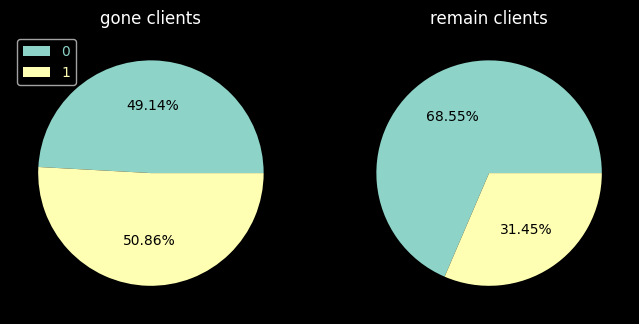

~~~~~~  Testing the null hypothesis on the parameter device_protection  ~~~~~~~


,device_protection,gone,remain
0,0,551,4070
1,1,550,1872


p-value: 3.742336045663829e-32
Reject the null hypothesis


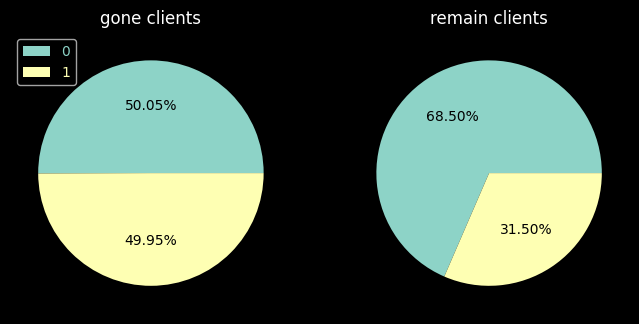

~~~~~~~~~  Testing the null hypothesis on the parameter tech_support  ~~~~~~~~~


,tech_support,gone,remain
0,0,703,4296
1,1,398,1646


p-value: 1.7331714072640974e-08
Reject the null hypothesis


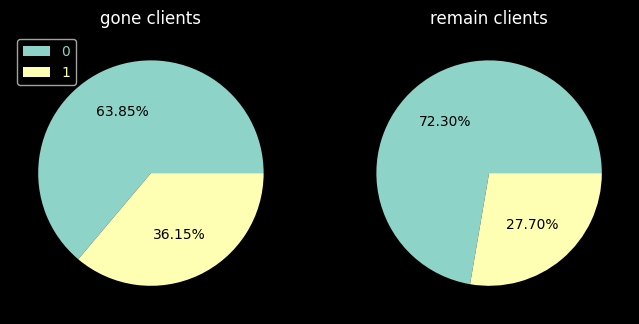

~~~~~~~~~  Testing the null hypothesis on the parameter streaming_tv  ~~~~~~~~~


,streaming_tv,gone,remain
0,0,517,3819
1,1,584,2123


p-value: 2.948361091032949e-27
Reject the null hypothesis


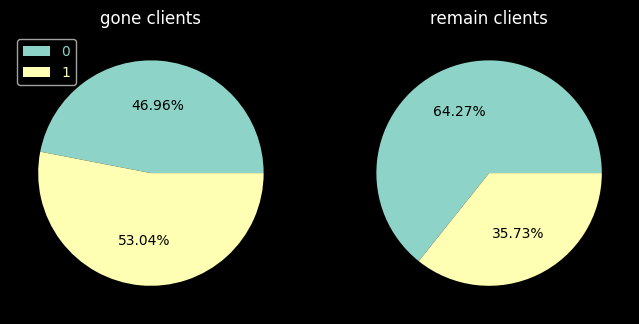

~~~~~~~  Testing the null hypothesis on the parameter streaming_movies  ~~~~~~~


,streaming_movies,gone,remain
0,0,495,3816
1,1,606,2126


p-value: 2.9992779995344396e-33
Reject the null hypothesis


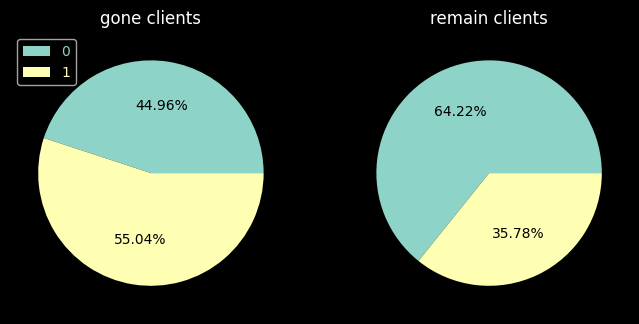

~~~~~~~~  Testing the null hypothesis on the parameter multiple_lines  ~~~~~~~~


,multiple_lines,gone,remain
0,0,320,3070
1,1,781,2872


p-value: 4.841986902951681e-43
Reject the null hypothesis


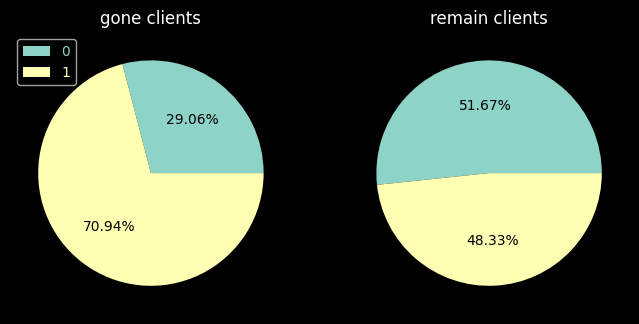

In [18]:
categorical_params = ['type', 'paperless_billing', 'payment_method', 'gender', 'partner', 'dependents', 'senior_citizen',
           'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support',
           'streaming_tv', 'streaming_movies', 'multiple_lines']

alpha = 0.05

def chi2(X):
    sum_table = df.groupby(X, as_index=False)['gone'].sum()
    count_table = df.groupby(X, as_index=False)['customer_id'].count()
    pivot = sum_table.merge(count_table, on=X)
    pivot['remain'] = pivot['customer_id'] - pivot['gone']
    pivot = pivot.drop('customer_id', axis=1)  
    stat, p, dof, expected = chi2_contingency(pivot[['gone', 'remain']])
    return pivot, p

for x in categorical_params:
    pivot, p_value = chi2(x)

    text = f'  Testing the null hypothesis on the parameter {x}  '
    print(f'{text:~^79}')

    display(pivot)
    
    print('p-value:', p_value)
    if p_value < alpha:
        print('Reject the null hypothesis')
    else:
        print('Failure to reject the null hypothesis')
    
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.pie(pivot['gone'], autopct='%1.2f%%', textprops={'color':"k"})
    plt.title('gone clients')
    plt.legend(labels=pivot[x], loc='upper left', labelcolor='linecolor')
    plt.subplot(1, 2, 2)
    plt.pie(pivot['remain'], autopct='%1.2f%%', textprops={'color':"k"})
    plt.title('remain clients')
    plt.show()

Multicollinearity check

interval columns not set, guessing: ['gone', 'paperless_billing', 'partner', 'dependents', 'senior_citizen', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']


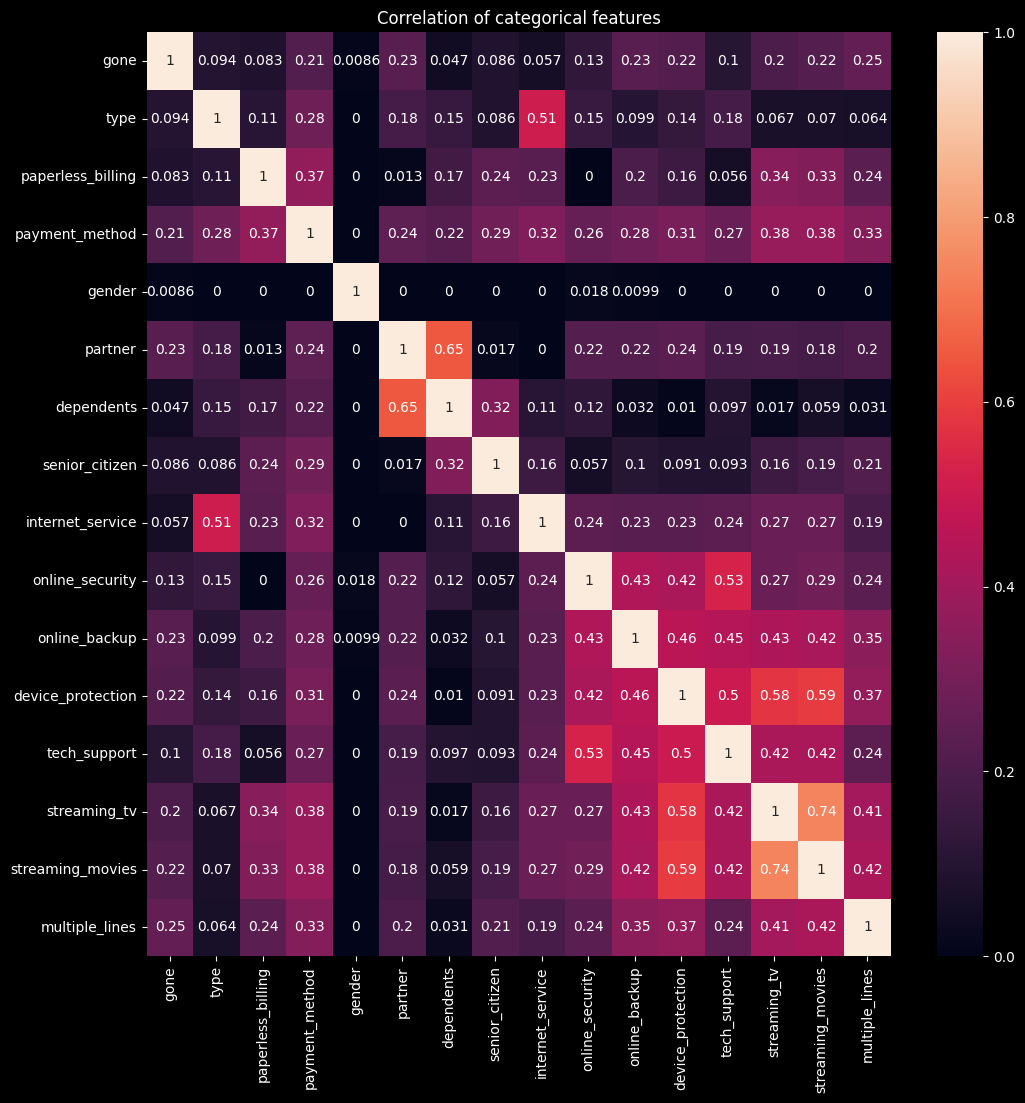

In [19]:
cat_corr_matrix = ['gone', 'type', 'paperless_billing', 'payment_method', 'gender', 'partner', 'dependents', 'senior_citizen',
           'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support',
           'streaming_tv', 'streaming_movies', 'multiple_lines']

plt.figure(figsize=(12, 12))
sns.heatmap(df[cat_corr_matrix].phik_matrix(), annot=True)
plt.title('Correlation of categorical features')
plt.show();

### conclusion on the analysis of categorical features

- The zero hypothesis deviates in almost all cases except the floor, therefore this sign is not mentioned and it can be removed, the rest affect the departure of customers to one degree or another and will be useful for teaching the model
- a severe correlation with a target feature in the categories was not noticed
- Services connected together with the Internet (`device_protection`, `streaming_tv`, `streaming_movies`) are strongly correlated.

### Analysis of Numeric Signs

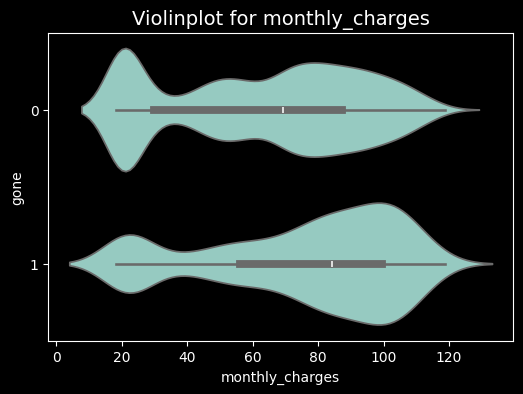

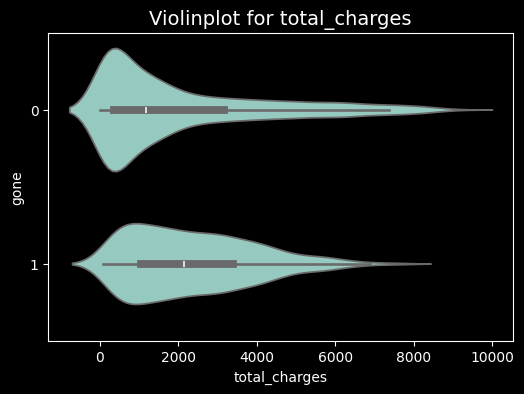

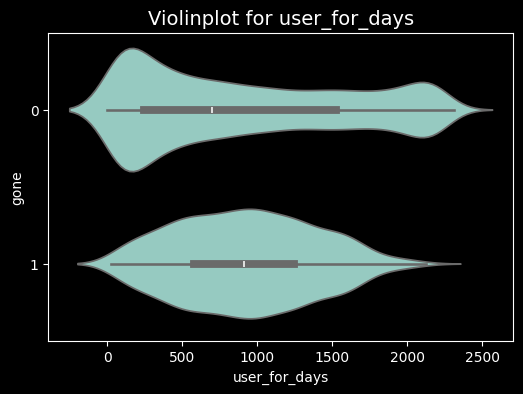

In [20]:
numeric_params = ['monthly_charges', 'total_charges', 'user_for_days']

for x in numeric_params:
    plt.figure(figsize=(6,4))
    plt.title('Violinplot for ' + x, fontsize=14)
    ax = sns.violinplot(y='gone', x=x, orient='h', data=df)
    
    plt.show()

Let's check whether the total costs will strongly correlate with the number of months the subscriber used the services

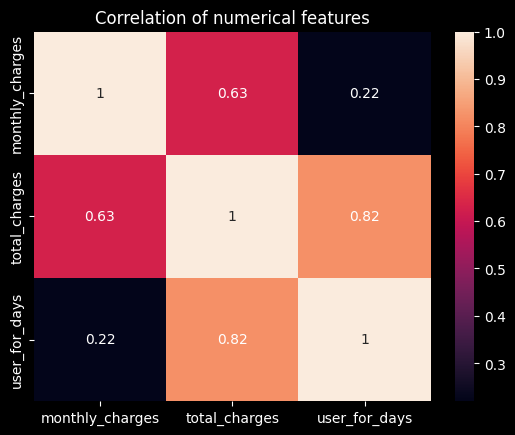

In [21]:
sns.heatmap(df[numeric_params].corr(), annot=True)
plt.title('Correlation of numerical features')
plt.show()

It would also be nice to look at the scatterplots depending on the target

<Figure size 800x800 with 0 Axes>

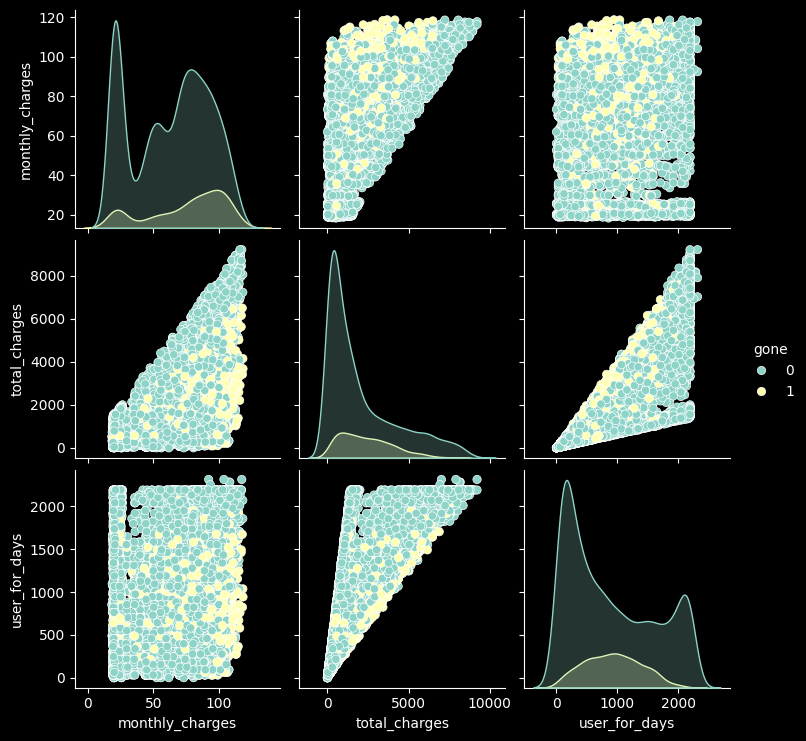

In [22]:
numeric_params_and_gone = ['monthly_charges', 'total_charges', 'user_for_days', 'gone']

plt.figure(figsize=(8,8))
sns.pairplot(df[numeric_params_and_gone], hue='gone')
plt.show();

### Conclusion on the analysis of numerical features

- The gone clients paid per month more than those who remain, mainly about 100, but there are those who paid a little more than 20 and still gone, although not so much and this hump coincides with the hump in the category of the remaining and rather caused by some Popular tariff plan
- a large share of gone, do it between 600 and 1300 days
- The total amount of funds spent is little informative. The `total_charges` parameter is very linearly correlating with the number of months of using services (`user_for_days`) and the monthly fee (`monthly_charges`), therefore, this parameter can be eliminated and the model will only become better from this.

In [23]:
df = df.drop(['customer_id', 'gender', 'total_charges'], axis=1)

### Data Analysis Conclusion

- data are loaded and analyzed
- Data is foster in one general Dataset
- Passes are filled in Dataset
- the target feature is allocated (customers who have gone)
- an additional feature is calculated, the number of months of use
- Removed the start and end dates of use
- hypotheses are put forward and tested in the importance of categorical features, based on which the floor is removed, as not affecting the outflow of customers
- the distribution of the bygone customers in the relationship with numerical features is analyzed, a strong linear dependence between the signs was revealed, as a result of which it was decided to get rid of a sign of the total cost of the user
- The `ID` of the crawler is also deleted as not necessary at the stage of training in the model
- At this stage, we left 14 signs + 1 target feature

### List of clarifying questions

- What metrics are better suited for the final model?It is important for the customer to predict all customers who are going to leave in order to minimize the outflow of customers (then you can offer a metric `recall`), or it is more important for him to minimize the costs of distributing promotional codes for those who are not going to leave and accuracy is important (then you can offer metrics `Precision`), or it is important for him to observe the middle ground between the metrics described above (then you can offer the metric `F1`).I advise you to also calculate the metric `ROC-AUC`.Maybe there are some other wishes?
- Can a new type of data appear hypothetically in categorical data or can I use the Get_Dummies method to encode these data?
- What is more important for the customer, the speed of training in the model or the quality of metrics?

### The purpose of the project

Training model of classification for predicting customer outflow

## further work plan
<a id="plan"> </a>

- Break the Dataset into signs and the target feature
-Break data into training and test samples (you can not do a validation sample, since it will be better to use the `K-Fold` cross-novelty)
- will determine the type of coding and apply it for the remaining categorical signs using `pipline`
- Determine the quality metric by which we will evaluate.
- choose various classification models and apply them
- Using Searchcv, choose the best parameters, starting from the selected metric for models
- choose a model that showed the best results for a ross validation
- Teach a model on test data
- Check the model for adequacy
- Draw conclusions
- Write a report on the work done

## Training models fwith cross-validation and finding the best

### Split dataset for training and test samples

In [24]:
X = df.drop('gone', axis=1)
y = df['gone']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE)

print('Training sample size:')
print(f'features {X_train.shape};')
print(f'target feature {y_train.shape}')
print(f'It is {round((y_train.count() / y.count()) * 100)}% of dataset')
print()
print('Test sample size:')
print(f'features {X_test.shape};')
print(f'target feature {y_test.shape}')
print(f'It is {round((y_test.count() / y.count()) * 100)}% of dataset')

Training sample size:
features (5282, 16);
target feature (5282,)
It is 75% of dataset

Test sample size:
features (1761, 16);
target feature (1761,)
It is 25% of dataset


### Creatinf common objects and functions for all models

In [25]:
results = pd.DataFrame(columns=['Model', 'best ROC-AUC', 'Accuracy with best ROC-AUC', 'best Accuracy', 'ROC-AUC with best Accuracy'])

cv = KFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)

preprocessor = ColumnTransformer(
    transformers=[
        ('to_scale', StandardScaler(), ['monthly_charges', 'user_for_days']),
        ('to_enc', OneHotEncoder(handle_unknown='ignore', drop='first'), ['type', 'payment_method', 'internet_service']),
        ('other', 'passthrough', ['paperless_billing', 'senior_citizen', 'partner', 'dependents',
                                   'online_security', 'online_backup', 'device_protection', 'tech_support', 
                                   'streaming_tv', 'streaming_movies', 'multiple_lines'])
        ]
    )

scoring = ['roc_auc', 'accuracy']

In [26]:
def sch_scores(prefix, full_model_name, n):
    
    globals()[f'{prefix}_best_roc_auc'] = eval(prefix+'_sch') \
        .cv_results_['mean_test_roc_auc'][np.where(eval(prefix+'_sch') \
        .cv_results_['rank_test_roc_auc'] == 1)[0][0]]
    
    globals()[f'{prefix}_best_accuracy'] = eval(prefix+'_sch') \
        .cv_results_['mean_test_accuracy'][np.where(eval(prefix+ \
        '_sch').cv_results_['rank_test_accuracy'] == 1)[0][0]]
    
    globals()[f'{prefix}_accuracy_per_roc_auc'] = eval(prefix+'_sch') \
        .cv_results_['mean_test_accuracy'][np.where(eval(prefix+ \
        '_sch').cv_results_['mean_test_roc_auc'] == eval(prefix+'_best_roc_auc'))[0][0]]
    
    globals()[f'{prefix}_roc_auc_per_accuracy'] = eval(prefix+'_sch') \
        .cv_results_['mean_test_roc_auc'][np.where(eval(prefix+ \
        '_sch').cv_results_['mean_test_accuracy'] == eval(prefix+'_best_accuracy'))[0][0]]
    
    print(f'{full_model_name}')
    print('~' *79)
    print('Best ROC-AUC with cross-validation: ', round(eval(prefix+'_best_roc_auc'), 4))
    print('accuracy with best ROC-AUC: ', round(eval(prefix+'_accuracy_per_roc_auc'), 4))
    print('with parameters: ', eval(prefix+'_sch').best_params_)
    print('~' *79)
    print('Best accuracy with cross-validation: ', round(eval(prefix+'_best_accuracy'), 4))
    print('ROC-AUC with best accuracy: ', round(eval(prefix+'_roc_auc_per_accuracy'), 4))

    results.loc[n] = [full_model_name, 
                    eval(prefix+'_best_roc_auc'),
                    eval(prefix+'_accuracy_per_roc_auc'),
                    eval(prefix+'_best_accuracy'),
                    eval(prefix+'_roc_auc_per_accuracy')
                    ]

In [27]:
def roc_auc_chart(model, X, y, prefix, full_model_name, size=5): 
    globals()[f'{prefix}_proba'] = model.predict_proba(X)
    globals()[f'{prefix}_proba_one'] = eval(prefix+'_proba')[:, 1]
    globals()[f'{prefix}_roc_auc'] = roc_auc_score(y, eval(prefix+'_proba_one'))
    globals()[f'{prefix}_fpr'], globals()[f'{prefix}_tpr'], globals()[f'{prefix}_treshold'] = roc_curve(y, eval(prefix+'_proba_one'))
    globals()[f'{prefix}_auc_score'] = auc(eval(prefix+'_fpr'), eval(prefix+'_tpr'))

    print(f'{full_model_name}: ROC-AUC = ', round(eval(prefix+'_roc_auc'), 4))

    plt.figure(figsize=(size, size))
    plt.title(f'{full_model_name}: ROC-curve')
    prefix_auc_score = eval(prefix+'_auc_score')
    plt.plot(eval(prefix+'_fpr'), eval(prefix + '_tpr'), color='darkorange',
            label=f'ROC curve (area = {round(prefix_auc_score, 4)})')
    plt.plot([0, 1], [0, 1], color='white', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show();

### LogisticRegressionClassifier

Find the parameters using `GridsearchCV`

LogisticRegressionClassifier
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Best ROC-AUC with cross-validation:  0.7523
accuracy with best ROC-AUC:  0.8586
with parameters:  {'model__C': 1.0}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Best accuracy with cross-validation:  0.8588
ROC-AUC with best accuracy:  0.7523

LogisticRegressionClassifier: ROC-AUC =  0.7585


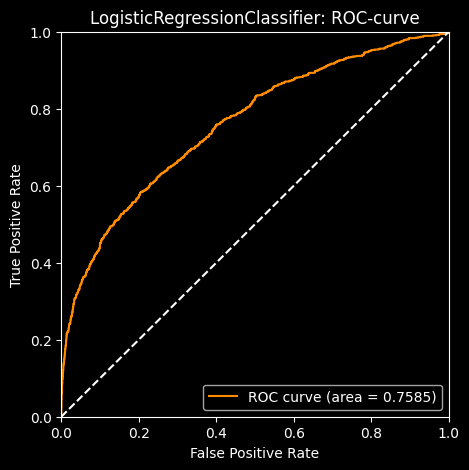

In [28]:
lr_parameters = {'model__C': [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 4.0, 9.0]}

lr_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', LogisticRegression(random_state=RANDOM_STATE,
                                                       max_iter=1000))])

lr_sch = GridSearchCV(lr_pipe,
                        lr_parameters,
                        cv=cv,
                        scoring=scoring,
                        refit='roc_auc',
                        error_score='raise'
                        )

lr_sch.fit(X_train, y_train)

sch_scores('lr', 'LogisticRegressionClassifier', 0)
print()
roc_auc_chart(lr_sch, X_train, y_train, 'lr', 'LogisticRegressionClassifier')

## RandomForestClassifier

Find the parameters using `RandomizedSearchcv`

RandomForestClassifier
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Best ROC-AUC with cross-validation:  0.8195
accuracy with best ROC-AUC:  0.8523
with parameters:  {'model__n_estimators': 800, 'model__min_samples_split': 12, 'model__min_samples_leaf': 3, 'model__max_depth': 8}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Best accuracy with cross-validation:  0.8567
ROC-AUC with best accuracy:  0.8133

LogisticRegressionClassifier: ROC-AUC =  0.9102


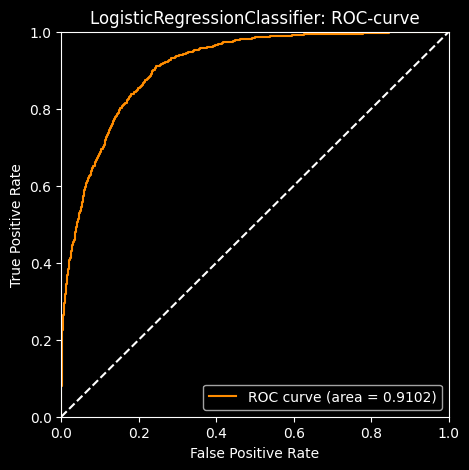

In [29]:
rf_parameters = {'model__n_estimators': range(100, 1001, 50),
                 'model__max_depth': range(1, 21),
                 'model__min_samples_split': range(1, 17),
                 'model__min_samples_leaf': range(1, 17)
                 }

# создаем пайплайн - объединяем преобразованные данные и модель
rf_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', RandomForestClassifier(random_state=RANDOM_STATE))
                          ])

rf_sch = RandomizedSearchCV(rf_pipe,
                            param_distributions=rf_parameters,
                            n_iter=100,
                            cv=cv,
                            scoring=scoring,
                            refit='roc_auc',
                            random_state=RANDOM_STATE
                            )

rf_sch.fit(X_train, y_train)

sch_scores('rf', 'RandomForestClassifier', 1)
print()
roc_auc_chart(rf_sch, X_train, y_train, 'rf', 'LogisticRegressionClassifier')

### LGBMClassifier

Find the parameters using `RandomizedSearchCV`

LGBMClassifier
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Best ROC-AUC with cross-validation:  0.9073
accuracy with best ROC-AUC:  0.9129
with parameters:  {'model__verbose': -1, 'model__num_leaves': 37, 'model__n_estimators': 700, 'model__max_depth': 4, 'model__learning_rate': 0.08}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Best accuracy with cross-validation:  0.9129
ROC-AUC with best accuracy:  0.9073

LGBMClassifier: ROC-AUC =  0.9948


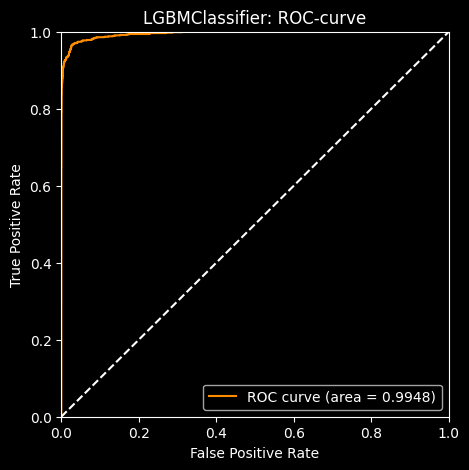

In [30]:
lgbm_parameters = {'model__n_estimators': range(100, 1001, 100),
                   'model__max_depth': [-1, 0, 1, 4, 8, 12, 16],
                   'model__num_leaves': range(20, 51),
                   'model__learning_rate': np.linspace(0.01, 0.2, 20),
                   'model__verbose': [-1]
                   }

lgbm_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', LGBMClassifier(random_state=RANDOM_STATE,
                                                     objective='binary'
                                                     )
                          )]
                     )

lgbm_sch = RandomizedSearchCV(lgbm_pipe,
                              param_distributions=lgbm_parameters,
                              n_iter=100,
                              cv=cv,
                              scoring=scoring,
                              refit='roc_auc',
                              random_state=RANDOM_STATE
                              )

lgbm_sch.fit(X_train, y_train)

sch_scores('lgbm', 'LGBMClassifier', 2)
print()
roc_auc_chart(lgbm_sch, X_train, y_train, 'lgbm', 'LGBMClassifier')

### Comparison of models

In [31]:
results

,Model,best ROC-AUC,Accuracy with best ROC-AUC,best Accuracy,ROC-AUC with best Accuracy
0,LogisticRegressionClassifier,0.7523,0.8586,0.8588,0.7523
1,RandomForestClassifier,0.8195,0.8523,0.8567,0.8133
2,LGBMClassifier,0.9073,0.9129,0.9129,0.9073


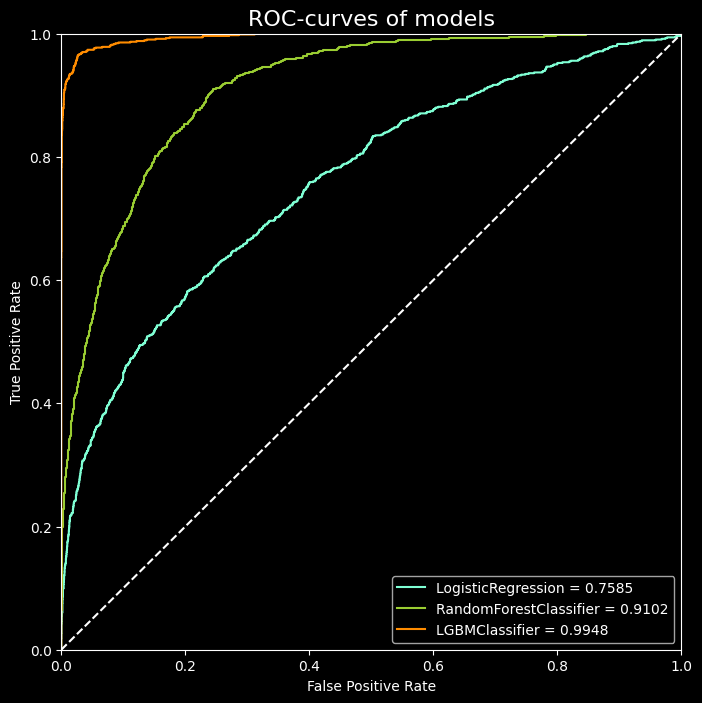

In [32]:
fig, ax = plt.subplots(figsize=(8,8))
plt.title('ROC-curves of models', fontsize=16)
ax.plot(lr_fpr, lr_tpr, color='aquamarine', label=f'LogisticRegression = {round(lr_auc_score, 4)}')
ax.plot(rf_fpr, rf_tpr, color='yellowgreen', label=f'RandomForestClassifier = {round(rf_auc_score, 4)}')
ax.plot(lgbm_fpr, lgbm_tpr, color='darkorange', label=f'LGBMClassifier = {round(lgbm_auc_score, 4)}')

plt.plot([0, 1], [0, 1], color='white', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show();

On ross validation, the best indicators of `Roc-Auc` shows `LGBMClassifier`, the best `Accuracy` is also behind it.
- The best indicators of `Roc-Auc` and `Accuracy` in this model are very close to each other in the sense that with the best indicators of one metrics, the second metric does not suffer much and vice versa.
- In other models, the balance between two metrics is worse and if you lift one, the second is softer more significant

An indisputable favorite in our comparison is `LGBMClassifier`
The parameters that we picked up:
- `num_leaves` = 37,
- `n_estimators` = 700,
- `max_depth` = 4,
- `learning_rate` = 0.08

## We will train the best model in a test sample

LGBMClassifier: ROC-AUC =  0.9163


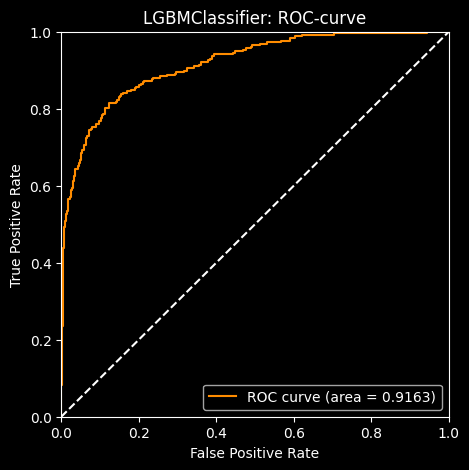

Best model accuracy on the test sample: 0.9211


In [37]:
test_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', LGBMClassifier(random_state=RANDOM_STATE,
                                                     class_weight='balanced',
                                                     objective='binary',
                                                     num_leaves=37,
                                                     n_estimators=700,
                                                     max_depth=4,
                                                     learning_rate=0.08,
                                                     verbose=-1
                                                     )
                          )]
                     )

test_pipe.fit(X_train, y_train)

roc_auc_chart(test_pipe, X_test, y_test, 'test', 'LGBMClassifier')

best_trashold = max([[accuracy_score(y_test, a), t] for a, t in [(test_proba_one > t, t) for t in np.arange(0, 1.01, 0.005)]], key=lambda x: x[0])[1]
predict = test_proba_one > best_trashold
test_accuracy = accuracy_score(y_test, predict)
print(f'Best model accuracy on the test sample: {round(test_accuracy, 4)}')

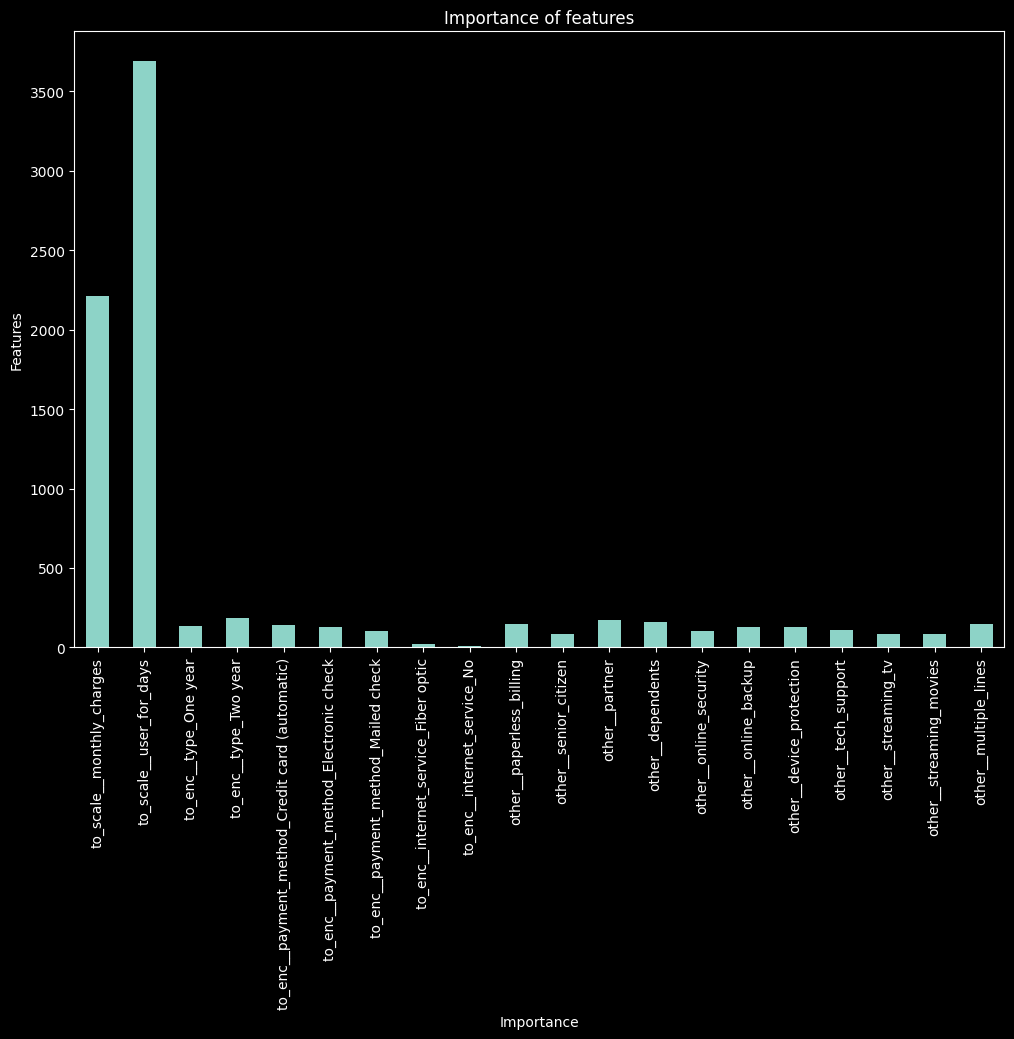

In [34]:
importances = pd.Series(test_pipe.steps[1][1].feature_importances_,
                         test_pipe.named_steps['preprocessor'].get_feature_names_out())

fig, ax = plt.subplots(figsize=(12,8))
importances.plot.bar(ax=ax)
plt.title('Importance of features')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

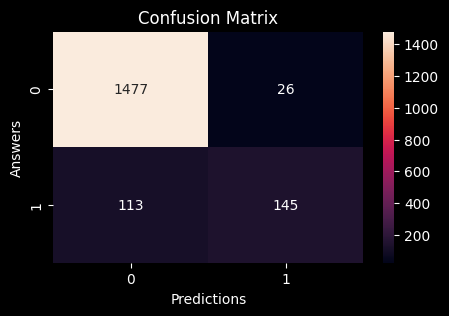

In [35]:
lgbm_cmxm = pd.DataFrame(confusion_matrix(y_test, predict))

plt.figure(figsize=(5,3))
plt.title('Confusion Matrix')
sns.heatmap(lgbm_cmxm, annot=True, fmt='d')
plt.xlabel('Predictions')
plt.ylabel('Answers')
plt.show()

### We will check the model for adequacy

In [36]:
dummy_clf = DummyClassifier(strategy="uniform", random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)
dummy_predict = dummy_clf.predict(X_test)
dummy_roc_auc = roc_auc_score(dummy_predict, y_test)
dummy_accuracy = accuracy_score(dummy_predict, y_test)

if test_roc_auc > dummy_roc_auc:
    print(f'ROC-AUC metric of our model ({round(test_roc_auc, 4)}) '
    f'higher than in random parameter fitting model '
    f'({round(dummy_roc_auc, 4)}), our model is adequate')
else:
    print(f'F1 metric of our model ({round(test_roc_auc, 4)}) '
    f'lower than in random parameter fitting model '
    f'({round(dummy_roc_auc, 4)}), our model is inadequate')

if test_accuracy > dummy_accuracy:
    print(f'Accuracy metric of our model ({round(test_accuracy, 4)}) '
    f'higher than in random parameter fitting model '
    f'({round(dummy_accuracy, 4)}), our model is adequate')
else:
    print(f'Accuracy metric of our model ({round(test_accuracy, 4)}) '
    f'lower than in the random parameter selection model '
    f'({round(dummy_accuracy, 4)}), our model is inadequate')

ROC-AUC metric of our model (0.9163) higher than in random parameter fitting model (0.4917), our model is adequate
Accuracy metric of our model (0.9211) higher than in random parameter fitting model (0.4855), our model is adequate


# Report

Work done:

Key steps:
- Data analysis
- Feature selection
- Search for parameters by cross-validation and choosing the best model
- Testing the best model

As a result of the work, the best model and parameters for it were found, it turned out to be `LGBMClassifier`.

In the test sample, the model showed the following metrics:
- `ROC-AUC` = 0.924
- `Accuracy` = 0.932

Steps in more detail:
- data are loaded and analyzed
- Data is foster in one general Dataset
- Passes are filled in Dataset
- from the sign `Enddate` selected the target sign (customers who are gone)
- an additional feature is calculated, the number of days of use (`user_for_days`) from the signs of the beginning and end of use (`begindate` and `enddate`)
    - Signs of the beginning and end of use (`begindate` and `enddate`) are removed as unnecessary
- hypotheses are put forward and tested in the importance of categorical signs
    - as a result of the audit, a decision was made to get rid of the floor of the floor (`gender`), since the hypothesis that this sign was not significant could not be rejected
- Analyzed multicollinearity of signs
    - As a result of the analysis, a decision was made to get rid of the sign of the total cost (`TotalchaRges`), since this feature greatly correlated with the rest of the quantitative features
- Remove the sign `Customerid`, this sign is unique to each line and do not need DLS of the training of the model
- Dataset is divided into training and test samples
- The `pipline` is used in which it is produced:
    - parallel processing:
        - Coding of categorical signs using `Onehotencoder`
        - Standardization of quantitative features using `Standartscler`
    - Model training
- To search for the best model and the best parameters for her, `Gridsearchcv` and `RandomizedSearchCV` were used.
- To assess the quality of models, `Roc-Auc` and `Accuracy` metrics were used
- The best moddel was among the following candidates:
    - `logisticregression`
    - `RandomForestClassifier`
    - `Lgbmclassifier`
- Found the best model and parameters for her, it turned out to be `LGBMClassifier`
    - The parameters that we picked up:
        - `num_leaves` = 37,
        - `n_estimators` = 700,
        - `max_depth` = 4,
        - `learning_rate` = 0.08
- The model is checked for adequate using `Dummyclassifier`

All points of Plan were completed

Difficulties arose:

- A lot of repeating, the same type of actions
    - solved by writing functions to automate these actions
- There was a difficulty in drawing a curve `roc-auc` on the results of cross-training
    - Brought down, although the result differs from what is issued by `RandomizedSearchCV`, which confuses